In [1]:
cd ../marathon/

/home/ubuntu/boston-marathon/marathon


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import marathonlib

In [3]:
def plot_model_deviation(model, X_train, y_train, X_test, y_test, y_max = 0.04):
    print 'Train R^2:', model.score(X_train, y_train)
    print 'Test R^2:', model.score(X_test, y_test)
    y_predict = model.predict(X_test)
    print 'Standard Error of Test:', marathonlib.time_to_timestring(np.var(y_test-y_predict)**0.5)
    plt.hist(y_test-y_predict, bins=100, range=(-100,250), normed=True, linewidth=0)
    plt.xlim(-100, 250)
    plt.ylim(0, y_max)
    plt.vlines(0, 0, 1)

In [4]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.dummy import DummyRegressor

In [5]:
df = pd.read_csv('data/boston2016_priors+.csv')
df15 = pd.read_csv('data/boston2016_clean.csv')

In [6]:
print df.shape

(106390, 26)


In [7]:
df.columns

Index([u'marathon', u'year', u'bib', u'name', u'firstname', u'lastname',
       u'age', u'gender', u'city', u'state', u'country', u'citizenship',
       u'offltime', u'prior_marathon', u'prior_year', u'prior_time', u'elite',
       u'qualifier', u'home', u'avgtemp', u'avghumid', u'avgwind', u'avgwindE',
       u'avgwindN', u'isgusty', u'rainhours'],
      dtype='object')

In [8]:
df15.columns

Index([u'marathon', u'year', u'bib', u'url', u'name', u'firstname',
       u'lastname', u'age', u'gender', u'city', u'state', u'country',
       u'citizenship', u'subgroup', u'gunstart', u'starttime', u'time5k',
       u'time10k', u'time15k', u'time20k', u'timehalf', u'time25k', u'time30k',
       u'time35k', u'time40k', u'pace', u'projtime', u'offltime', u'nettime',
       u'overall_rank', u'gender_rank', u'division_rank', u'other1', u'other2',
       u'other3', u'other4'],
      dtype='object')

In [9]:
# remove duplicate runners from priors+, results from runners who have ran more than one other race.
def get_unique_runners(df, func=np.median):
    unique_bibs = df['bib'].unique()
    runners_list = []
    for bib in unique_bibs:
        runners = df[df['bib'] == bib]
        runner = runners.iloc[0].copy()
        if len(runners > 1):
            runner['prior_year'] = func(runners['year'])
            runner['prior_marathon'] = ''
            runner['prior_time'] = func(runners['prior_time'])
        runners_list.append(runner)
    #unique_df = pd.concat(runners_list, axis=1).T
    unique_df = pd.DataFrame().append(runners_list)
    return unique_df

In [10]:
sum(df['prior_time'].isnull())

0

In [11]:
unique_df = get_unique_runners(df).copy()
print unique_df.shape

(22935, 26)


In [12]:
len(df['prior_marathon'].unique())

929

In [13]:
print '# of prior records:', len(df)
print '# of unique runners w/priors:', len(unique_df)
print '# of runners in 2016:', len(df15)
print '2016 Runners found: {:.1f}%'.format(len(unique_df) * 100. / len(df15))

# of prior records: 106390
# of unique runners w/priors: 22935
# of runners in 2016: 26437
2016 Runners found: 86.8%


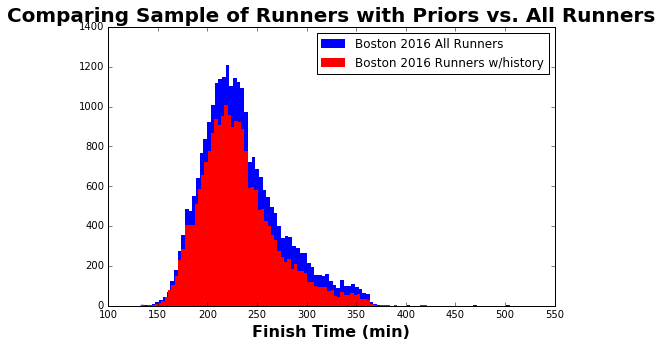

Boston 2016 w/priors: 230.619904753
Boston 2016: 235.003312277


In [14]:
# Finish times of Boston compared with priors
fig = plt.figure(figsize=(8, 5))
plt.hist(df15['offltime'], bins=100, label='Boston 2016 All Runners', linewidth=0, color='b')
plt.hist(unique_df['offltime'], bins=100, label='Boston 2016 Runners w/history', linewidth=0, color='r')
plt.legend()
plt.title('Comparing Sample of Runners with Priors vs. All Runners', fontsize=20, weight='bold')
plt.xlabel('Finish Time (min)', fontsize=16, weight='bold')
plt.savefig('test.png', transparent=True)
plt.show()
print 'Boston 2016 w/priors:', df['offltime'].mean()
print 'Boston 2016:', df15['offltime'].mean()

Even though we've captured 86+% of runners, the averages are off.  Is it possible our missing runners are runners who do not run marathons, and are running a professional course for the first time?

# of bib numbers with no priors:  3478


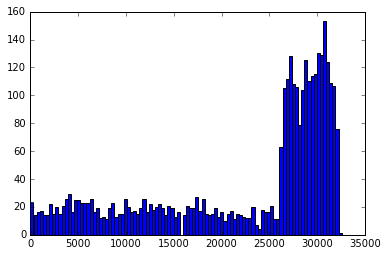

In [15]:
priorbibs = set(df['bib'])
missing_bibs = [bib for bib in df15['bib'] if bib not in priorbibs]
print '# of bib numbers with no priors: ', len(missing_bibs)
plt.hist(missing_bibs, bins=100)
plt.show()

###### For 2015, non-qualifiers were assigned bib numbers > ~26,000 (aka Charity runners).  It appears a chunk of our runners are indeed first timers.  But we are missing running histories for other runners too.

### Build Dataframe for Modelling

In [16]:
# One row per running record.  We will combine runner predictions later
feature_columns = [u'bib', u'age', u'gender', u'elite', u'qualifier', 
                   u'home', 
                   u'avgtemp', u'avghumid', u'avgwind', u'avgwindE', u'avgwindN', u'isgusty',
                   u'rainhours','prior_year', 'prior_time', 'prior_marathon']
#model_df = pd.get_dummies(unique_df[feature_columns])
model_df = pd.get_dummies(df[feature_columns])
X = model_df.values
y = df['offltime'].values
print X.shape, y.shape

(106390, 1007) (106390,)


### Mean as a Model

Train R^2: 0.0
Test R^2: 0.0
Standard Error of Test: 0:37:24


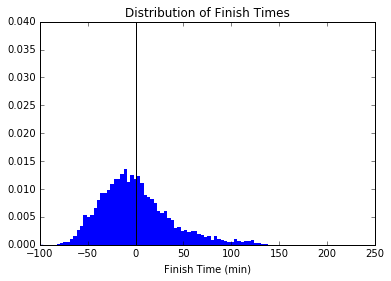

In [17]:
model = DummyRegressor()
model.fit(X, y)
plot_model_deviation(model, X, y, X, y)
plt.title('Distribution of Finish Times')
plt.xlabel('Finish Time (min)')
plt.show()

### Regression Model

Train R^2: 0.622621303717
Test R^2: 0.622621303717
Standard Error of Test: 0:22:59


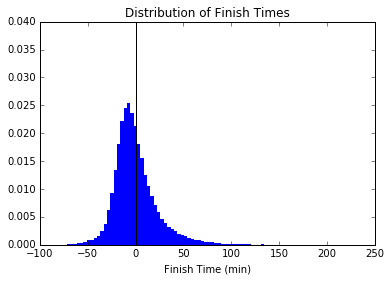

In [18]:
model = LinearRegression()
model.fit(X, y)
plot_model_deviation(model, X, y, X, y)
plt.title('Distribution of Finish Times')
plt.xlabel('Finish Time (min)')
plt.show()

Train R^2: 0.603680129931
Test R^2: 0.603680129931
Standard Error of Test: 0:23:33

Lasso Coefficients (alpha= 1 )
------------------
intercept 137.908892199
bib       0.00253844591611
age       0.332165963099
avgtemp   -0.0184463241822
avghumid  -0.00315556027531
avgwindE  -0.0137634799578
prior_time0.183196108389


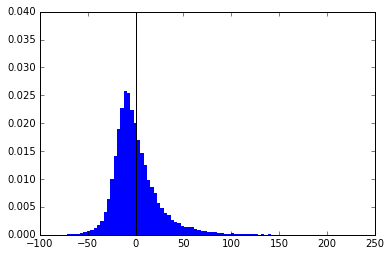

In [19]:
alpha = 1
model = Lasso(alpha=alpha)
model.fit(X, y)
plot_model_deviation(model, X, y, X, y)
print 
print 'Lasso Coefficients (alpha=',alpha,')'
print '------------------'
print '{0:10}{1}'.format('intercept', model.intercept_)
for name, coef in zip(model_df.columns, model.coef_):
    if abs(coef) > 0.001:
        print '{0:10}{1}'.format(name, coef)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=732)
print X_train.shape, y_train.shape

(79792, 1007) (79792,)


In [21]:
print X_test.shape, y_test.shape

(26598, 1007) (26598,)


Train R^2: 0.693728211644
Test R^2: 0.6812611642
Standard Error of Test: 0:21:10


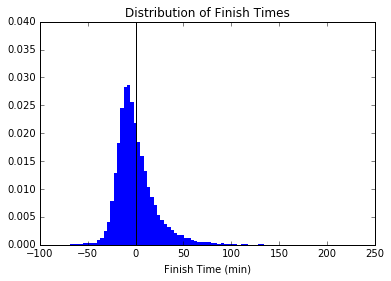

In [22]:
model = GradientBoostingRegressor(n_estimators=200, learning_rate = 0.04, max_depth=4, subsample=0.6)
model.fit(X_train, y_train)
plot_model_deviation(model, X_train, y_train, X_test, y_test)
plt.title('Distribution of Finish Times')
plt.xlabel('Finish Time (min)')
plt.savefig('priormodel-gradientboosting.png', bbox_inches='tight', dpi=300)
plt.show()

Train R^2: 0.571398338424
Test R^2: 0.5410432335
Standard Error of Test: 0:25:24


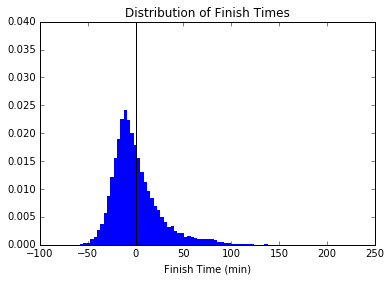

In [23]:
model = RandomForestRegressor(max_depth = 16, max_features = 43, n_estimators = 1000)
model.fit(X_train, y_train)
plot_model_deviation(model, X_train, y_train, X_test, y_test)
plt.title('Distribution of Finish Times')
plt.xlabel('Finish Time (min)')
plt.savefig('priormodel-randomforest.png', bbox_inches='tight', dpi=300)
plt.show()

# Pick model

Since we need to train on entire dataset and use the results, we need a model that does not overfit.

### Gradient Boosting Wins

## 1. Tune Gradient Boosting

In [ ]:
# Tune using CV search
# model = GridSearchCV(GradientBoostingRegressor(verbose=True), 
#                      param_grid={'n_estimators': [100],
#                                  'learning_rate': [0.04],
#                                  'max_depth': [4],
#                                  'subsample': [0.7, 0.6, 0.5]},
#                      verbose=True)
# model.fit(X_train, y_train)
# print model.best_params_

In [ ]:
# Bump up the number of estimators and now tune learning_rate
# model = GridSearchCV(GradientBoostingRegressor(verbose=True), 
#                      param_grid={'n_estimators': [500],
#                                  'learning_rate': [0.04, 0.01, 0.003, 0.001],
#                                  'max_depth': [4],
#                                  'subsample': [0.6]},
#                      verbose=True)
# model.fit(X, y)
# print model.best_params_
# plot_model_deviation(model, X, y, X, y)
# plt.title('Distribution of Finish Times')
# plt.xlabel('Finish Time (min)')
# plt.show()

## 2. Fit on entire dataset (- extreme outliers)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1        1319.4877          70.1597           26.61m
         2        1265.2510          63.9260           26.49m
         3        1208.9045          59.3554           26.31m
         4        1155.5249          54.6069           26.10m
         5        1100.3748          50.9607           25.95m
         6        1059.3841          46.2191           25.79m
         7        1004.3194          43.2101           25.63m
         8         971.2490          40.0986           25.48m
         9         940.5401          36.7689           25.34m
        10         895.1470          34.3853           25.21m
        20         670.4295          15.4274           23.81m
        30         564.8017           7.3402           22.43m
        40         513.7937           3.5937           21.08m
        50         484.6613           1.9064           19.70m
        60         474.3865           0.9459           18.31m
       

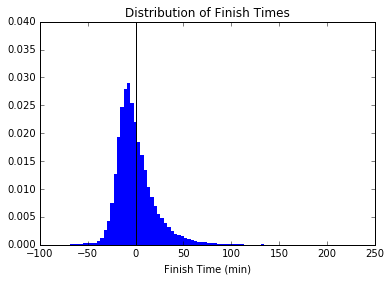

In [24]:
model = GradientBoostingRegressor(n_estimators=200, learning_rate = 0.04, max_depth=4, subsample=0.6, verbose=True)
model.fit(X, y)
plot_model_deviation(model, X, y, X, y)
plt.savefig('finalmodel-gradientboosting.png', bbox_inches='tight', dpi=300)
plt.title('Distribution of Finish Times')
plt.xlabel('Finish Time (min)')
plt.show()

In [25]:
# Remove outliers > 3 std deviations away
y_predict = model.predict(X)
stddev = np.var(y - y_predict)**0.5
outlier = abs(y-y_predict) > 3*stddev

X_clean = model_df[~outlier].values
y_clean = df.loc[~outlier, 'offltime'].values
print X_clean.shape, y_clean.shape

(104573, 1007) (104573,)


In [26]:
# Refit model without outliers
model = GradientBoostingRegressor(n_estimators=200, learning_rate = 0.04, max_depth=4, subsample=0.6, verbose=True)
model.fit(X_clean, y_clean)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1        1205.8544          69.5861           25.75m
         2        1134.5636          64.4623           25.64m
         3        1080.1485          59.6592           25.52m
         4        1017.1501          55.4356           25.36m
         5         966.1672          50.8425           25.24m
         6         912.6703          47.5097           25.08m
         7         874.4507          43.3890           24.96m
         8         834.5618          39.9603           24.84m
         9         797.5361          37.3156           24.71m
        10         768.3073          33.8567           24.58m
        20         542.9170          15.4886           23.28m
        30         428.7731           7.3877           21.98m
        40         379.2494           3.3922           20.66m
        50         354.0238           1.7617           19.30m
        60         337.4252           1.0212           17.95m
       

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.04, loss='ls',
             max_depth=4, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=200,
             presort='auto', random_state=None, subsample=0.6,
             verbose=True, warm_start=False)

Train R^2: 0.758082878852
Test R^2: 0.758082878852
Standard Error of Test: 0:17:31


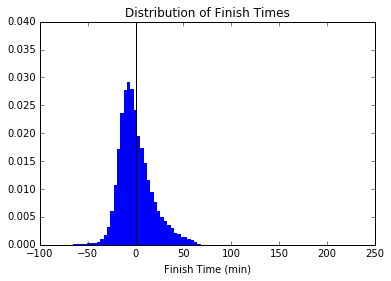

In [27]:
plot_model_deviation(model, X_clean, y_clean, X_clean, y_clean)
plt.title('Distribution of Finish Times')
plt.xlabel('Finish Time (min)')
plt.savefig('finalmodel-gradientboosting.png', bbox_inches='tight', dpi=300)
plt.show()

In [28]:
feature_importance = zip(model_df.columns, model.feature_importances_)
sorted(feature_importance, reverse=True, key=lambda x: x[1])[0:20]

[('bib', 0.42431661009909905),
 ('prior_time', 0.15789584947123111),
 ('age', 0.13378743300945525),
 ('avgtemp', 0.024387426406978444),
 ('prior_year', 0.018245320891419642),
 ('home_UT', 0.015849919046025829),
 ('gender', 0.015150129455080763),
 ('prior_marathon_boston', 0.010459089241655131),
 ('home_GA', 0.0089089581835354852),
 ('home_CAN', 0.0076527108611290631),
 ('prior_marathon_revel_canyon_city', 0.0074971486178948563),
 ('home_NJ', 0.0072647077573554522),
 ('home_MO', 0.0070962355780505295),
 ('home_MISC', 0.0069268329488645494),
 ('prior_marathon_st_george', 0.0068885871650971276),
 ('avghumid', 0.0068111873410827764),
 ('home_HI', 0.0066273352049880559),
 ('home_MN', 0.0062985318344250399),
 ('prior_marathon_big_cottonwood_half', 0.006198329925714785),
 ('avgwindE', 0.0055033906208062037)]

## 3. Select outliers.

Train R^2: 0.681643304759
Test R^2: 0.681643304759
Standard Error of Test: 0:21:04


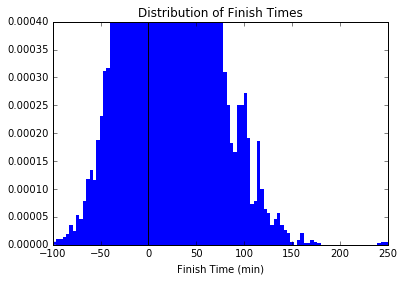

In [29]:
# Plot showing outliers
plot_model_deviation(model, X, y, X, y, y_max = 0.0004)
plt.title('Distribution of Finish Times')
plt.xlabel('Finish Time (min)')
plt.savefig('outliers-zoom.png', bbox_inches='tight', dpi=300)
plt.show()

In [30]:
y_predict = model.predict(X)

In [32]:
model_df['predicted_time'] = y_predict

In [33]:
stddev = np.var(y - y_predict)**0.5
outliers = (y - y_predict > 1 * stddev)
outlier_bibs = df.loc[outliers, 'bib'].unique()

print 'Standard Error:', stddev
print '# of outlier records:', sum(outliers)
print
print 'Total # of unique runners:', len(df['bib'].unique())
print '# of unique outliers:', len(df.loc[outliers, 'bib'].unique())


Standard Error: 21.0613012682
# of outlier records: 14036

Total # of unique runners: 22935
# of unique outliers: 3663


In [34]:
# remove duplicate runners from priors+, results from runners who have ran more than one other race.
def get_uniques(df):
    unique_bibs = df['bib'].unique()
    runners_list = []
    for bib in unique_bibs:
        runners = df[df['bib'] == bib]
        runner = runners.iloc[0].copy()
        runner['predicted'] = np.mean((runners['predicted']))
        runner['difference'] = runner['offltime'] - runner['predicted']
        runner['median_difference'] = runner['offltime'] - np.median((runners['predicted']))
        runner['min_difference'] = runner['offltime'] - np.min((runners['predicted']))
        runner['max_difference'] = runner['offltime'] - np.max((runners['predicted']))
        if len(runners) > 1:
            # If multiple records exist for a runner, then save the following columns
            runner['2ndmin_difference'] = runner['offltime'] - list(runners['predicted'].sort_values())[1]
            runner['2ndmax_difference'] = runner['offltime'] - list(runners['predicted'].sort_values())[-2]
        else:
            runner['2ndmin_difference'] = runner['difference']
            runner['2ndmax_difference'] = runner['difference']
        runners_list.append(runner)
    unique_df = pd.DataFrame(runners_list)
    return unique_df

In [35]:
# Make cheater prediction table
# bib, y, y_predict, cheater
predict_df = pd.DataFrame(model_df['bib'])
predict_df['offltime'] = y
predict_df['predicted'] = y_predict
predict_df['difference'] = y - y_predict
print predict_df.shape
predict_df = get_uniques(predict_df)
print predict_df.shape

(106390, 4)
(22935, 9)


In [36]:
print predict_df['difference'].min(), predict_df['difference'].max()

-113.214875967 245.065199008


In [38]:
# Set threshold at 30.0 min
threshold = 30.0
flagged = predict_df.loc[predict_df['max_difference'] > threshold]
out_str = '{:9.1f}  {:8}  {:7}  {:4.2f}'
print 'threshold  cheaters  records  rate'
print '---------  --------  -------  ----'
print out_str.format(threshold, 0, len(flagged), 0)

threshold  cheaters  records  rate
---------  --------  -------  ----
     30.0         0     1579  0.00


# Save Outlier List

In [39]:
flagged

,bib,offltime,predicted,difference,median_difference,min_difference,max_difference,2ndmin_difference,2ndmax_difference
19,24981,349.333333,260.083924,89.249409,89.374673,94.777918,82.034839,90.864516,87.637752
79,5923,250.933333,203.108893,47.824440,48.267144,51.246330,42.520360,50.391329,45.908495
81,8905,265.966667,215.162656,50.804010,48.851407,55.982282,47.475150,52.950804,48.760408
88,12427,285.800000,223.241443,62.558557,62.666517,65.131016,60.597917,63.302892,60.748596
104,10773,297.000000,218.814472,78.185528,78.017767,79.050587,77.488230,78.017767,78.017767
112,12666,269.500000,218.362662,51.137338,50.913923,53.068640,49.159393,52.056290,50.488443
113,18262,277.633333,238.853197,38.780136,37.704433,42.940416,36.771262,37.920104,37.488762
122,26217,415.816667,311.589053,104.227614,96.160452,127.609087,94.113655,123.518690,95.137615
124,6044,344.800000,205.526636,139.273364,138.352474,142.549325,136.979343,142.378479,137.091759
137,2055,233.116667,189.473187,43.643479,44.378754,46.274329,41.081470,44.916012,41.566831


In [40]:
flagged.to_csv('data/2016-flagged1.csv')